# Global Overturning Streamfunction

This script is a test case for the OOD proof of concept testing.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cmocean as cm

In [2]:
session = cc.database.create_session()

In [3]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [4]:
cluster = SLURMCluster(cores=4,memory="47GB",walltime="10:00:00")
client = Client(cluster)

In [9]:
cluster.scale(cores=56)

In [10]:
cluster

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:45919,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


CPU times: user 9min 22s, sys: 44.4 s, total: 10min 6s
Wall time: 20min 37s


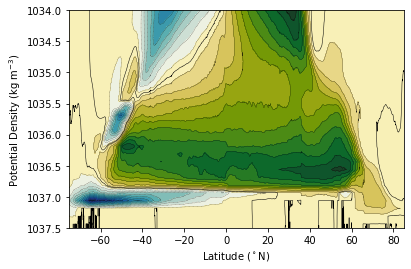

In [12]:
%%time
experiment = '01deg_jra55v13_ryf9091'
start_time='1950-01-01'
end_time='2049-12-31'
chunking={"time":12,"potrho":40,"grid_yu_ocean":540,"grid_xt_ocean":720}
psi = cc.querying.getvar(experiment,'ty_trans_rho',session,
                         start_time=start_time, end_time=end_time, 
                         frequency='1 monthly',chunks=chunking)
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
psi_avg.load()

p1 = plot_psi(psi_avg)

## Open On Demand 
| Workers | Cores | Memory | Number of years | CPU Time (s) | Wall Time (s) |  Notes | 
|----|----|----| ----|----|----|----|
| 0 | ? | ? | 1 | died | | Assume I don't have enough memory without a cluster |
| 4 | 8 | 28.88 Gb | 1 | 110 | 165 |  SLURMCluster(cores=8,memory="31GB")|
| 8 | 16 | 57.76 Gb | 1 | 97 | 129 |   |
| 8 | 16 | 57.76 Gb | 1 | 295 | 724 | New session. Seemed slow to start. Very slow to finish?? Not sure what is wrong here. |
| 8 | 16 | 57.76 Gb | 1 | 92 | 116 | Same session and cluster as above. Strange. Let's try again! |
| 8 | 16 | 57.76 Gb | 1 | 96 | 116 | Third time, just to check. |
| 8 | 32 | 57.76 Gb | 1 | 490 | 1554 | Trying SLURMCluster(cores=16,memory="31GB"). Very slow again...  |
| 16 | 16 | 115.52 GB | 1 | 96 | 120 | Hmm ... |
| 32 | 32 | 231.04 GB | 1 | 97 | 120 | OK. | 
| 32 | 32 | 231.04 GB | 5 |  |  | Gave up, for now. | 
| 12 | 12 | 173.28 GB | 1 | 30 | 110 | Using chunks={"time":1,"potrho":8,"grid_yu_ocean":2700,"grid_xt_ocean":3600} and 16 cores on OOD session | 
| 12 | 12 | 173.28 GB | 1 | 14 | 43 | Using chunks={"time":10,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} and 16 cores on OOD session | 
| 12 | 12 | 173.28 GB | 5 | 69 | 184 | Using chunks={"time":10,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} and 16 cores on OOD session | 
| 12 | 12 | 173.28 GB | 20 | 236 | 643 | Using chunks={"time":10,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} and 16 cores on OOD session | 


## Gadi-Jupyter - normal queue
| Workers | Cores | Memory | # of years | CPU Time (s) | Wall Time (s) |  Notes | 
|----|----|----| ----|----|----|----|
| 8 | 16 | 64 Gb | 1 | 48 | 69 |   |
| 8 | 16 | 64 Gb | 1 | 47 | 57 | Second run just to check  |
| 8 | 16 | 64 Gb | 5 | 377 | 513 |  Slower than it should have been. Struggled with memory. |
| 8 | 16 | 64 Gb | 5 | 423 | 630 |  Checking. |
| 4 | 16 | 64 Gb | 10 | 1725 | 2282 |  Struggling! ... |
| 4 | 48 | 188.57 Gb | 10 | 586 | 767 |  Better! |
| 8 | 48 | 188.57 Gb | 10 | 294 | 388 |  Perhaps optimal? |
| 16 | 48 | 188.57 Gb | 10 | 417 | 487 | Looked pretty inefficient while running, but quicker. |
| 8 | 16 | 64 Gb | 50 | - | - | Ran out of memory  |
| 8 | 48 | 188.57 Gb | 50 | - | - |  Garbage collection warnings ... killed workers, etc.|
| 4 | 48 | 188.57 Gb | 50 | - | - |  |
| 12 | 48 | 188.57 Gb | 20 | 151 | 324 | Using chunks={"time":10,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} |
| 12 | 48 | 188.57 Gb | 20 | 435 | 878 | Using chunks={"time":30,"potrho":8,"grid_yu_ocean":100,"grid_xt_ocean":3600} |
| 12 | 48 | 188.57 Gb | 20 | 124 | 235 | Using chunks={"time":50,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} |
| 12 | 48 | 188.57 Gb | 50 | 475 | 777 | Using chunks={"time":50,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} |
| 12 | 48 | 188.57 Gb | 100 | 462 | 815 | Using chunks={"time":50,"potrho":8,"grid_yu_ocean":270,"grid_xt_ocean":3600} |


## How does Slurm allocate cores and memory?

| SLURM cores | SLURM memory | cluster.scale(cores=?)  | client workers | client cores | client memory |
|---|---|---|---|---|---|
| 16 | 31 | 4 | 4 | 16 |28.88 | 
| 16 | 31 | 8 | 4 | 16 |28.88 | 
| 16 | 31 | 16 | 4 | 16 | 28.88 | 
| 16 | 31 | 32 | 8 | 32 | 57.76 | 
| 8 | 31 | 4 | 4 | 8 | 28.88 |
| 8 | 31 | 8 | 8 | 8 | 28.88 |
| 8 | 31 | 16 | 8 | 16 | 57.76 |
| 8 | 31 | 32 | 16 | 32 | 115.52 |
| 4 | 31 | 4 | 4 | 4 | 28.88 |
| 4 | 31 | 8 | 8 | 8 | 57.76 |
| 4 | 31 | 16 |16 | 16 | 115.52 |
| 4 | 31 | 32 | 32 | 32 | 231.04 |
| 2 | 31 | 4 | 4 | 4 | 57.76 |
| 2 | 31 | 8 | 6 | 6 | 86.64 |

I still find this strange -- but I think the way we should use this is:
* if you want multiple threads per worker, go for `SLURMCluster(cores=16,memory="31GB")`
* if you want lots of memory per worker, go for `SLURMCluster(cores=4,memory="31GB")`
* Then scale up cores, or number of workers via `cluster.scale()`
* As far as we can tell, `cluster.adapt()` doesn't work